This script explains an end-to-end classification example using the <a href="https://kdd.ics.uci.edu/databases/20newsgroups">20_Newsgroup dataset</a>.

We go through the dataset acquisition and loading, preprocessing, and further training and prediction of an RNN inspired model.

We retake the following scripts:

- `dataset/news.py`
- `preprocessing/simple_preprocessing.py`
- `model/classification/lstm_model.py`

---
All the instructions we use here are also in the mentioned scripts. Nonetheless, we aimed to perform the complete process without using the `conabio_ml.Pipeline` manager.

In [ ]:
!echo $PYTHONPATH

In [ ]:
import os
import json
import tarfile

from pathlib import Path
from pprint import pprint

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Dropout, Bidirectional

In [ ]:
from conabio_ml.pipeline import Pipeline

from conabio_ml_text.datasets import Dataset
from conabio_ml_text.preprocessing.preprocessing import Tokens, PreProcessing
from conabio_ml_text.utils.constraints import TransformRepresentations as TR
from conabio_ml_text.preprocessing.transform import Transform

from conabio_ml_text.trainers.bcknds.tfkeras import TFKerasBaseModel
from conabio_ml_text.trainers.bcknds.tfkeras_models import TFKerasRawDataModel
from conabio_ml_text.trainers.bcknds.tfkeras import TFKerasTrainer, TFKerasTrainerConfig
from conabio_ml_text.trainers.bcknds.tfkeras import CHECKPOINT_CALLBACK, TENSORBOARD_CALLBACK

from examples.utils import download_dataset, news_item_reader
from examples.utils import simple_item_preprocessing

First, we download and untar the `20_Newsgroups` dataset. This process produces a folder with 20 subfolders that correspond to each label.

From here, we will use the methods of the `conabio_ml`/`conabio_ml_text` libraries. By wrapping each step of the ML experiment we enforce reproducibility and reporting.

In [ ]:
results_path = Path("./results")

results_path.mkdir(exist_ok=True)

URL = "https://kdd.ics.uci.edu/databases/20newsgroups/20_newsgroups.tar.gz"
dest_dataset = results_path / "20news.tar.gz"
dataset_path = results_path / "20_newsgroups"

# If you already have the dataset ommit the following steps.
download_dataset(URL, dest_dataset)

tar = tarfile.open(dest_dataset)
tar.extractall(path=results_path)
tar.close()

## Dataset

The `Dataset.from_folder` method creates a human-readable dataset, it will be kept during the complete experiment. This dataset should contain at least the `item` and the `label` columns. 

The content of the `label` column is populated by the name of the folder each sample comes from. (Since we are using `split_by_folder= False`)

The content of the file, destined to populate the `item` column, could be almost anything and could be preprocessed using different methods. By default, a pre-implemented function is available. Nevertheless, you can add a handler to a function to process the content of the file.

In this example, we override the default implementation using the method `news_item_reader`.

---
<b>Note:</b> Every custom reader need to implement a signature, as described:

```python
def news_item_reader(filepath: str)

where:
    filepath: Is the path of the document
```

In [ ]:
assert dataset_path.exists(), f"Dataset path not found"

dataset = Dataset.from_folder(source_path = dataset_path,
                              recursive= True,
                              extensions =["txt"],
                              split_by_folder= False,
                              item_reader= news_item_reader)


In [ ]:
dataset = Dataset.split(dataset,
                        train_perc= 0.8,
                        test_perc= 0.1,
                        val_perc= 0.1,
                        split_params= {
                            "random_state": 42
                         })

The reporting process is still available, but you can make it manually. Every stage has a `reporter` function attached, as shown:

In [ ]:
dataset.reporter(results_path/"dataset_split", {})

## Preprocessing

Preprocessing stage could differ according to the experiment itself. 

A prebuilt basic preprocessing is available in the library. If you have a custom preprocessing scenario, you have two options of implementation:
1. If the processing step is simple, you can create a custom preprocessing function and notify it to the `Preprocessing.preprocess` method, as seen in the example.

    You have to take care of two requirements:
    - The signature of the function
    ```python
    def simple_item_preprocessing(item: str, preproc_args: {}) -> str:
    ```
    
    - Report the params of the custom method vía `func_args`.

    ```python
    def simple_item_preprocessing([…], 
                                  preproc_args: {} # These correspond to preprocess_args['func_args']
                                 ) -> str:
    ```

2. If the processing is more complex, subclass `Preprocessing`. As shown in <a href="">this example</a>

In [ ]:
dataset = PreProcessing.preprocess(dataset, 
                                  build_vocab = True, 
                                  vocab_args = {
                                      "vocab_size": 5000
                                  },
                                   preprocess_fn= simple_item_preprocessing,
                                   preprocess_args= {
                                       "func_args": {
                                           "remove_symbols": True,
                                           "padding_size": 200
                                       }
                                   })

## Dataset transformation

Transformations are the key parts to train a machine learning model. They respond to the backend the model will use. (You can check the available transformations <a href="">in the following link</a>.)

You can imagine the transformations as the bridges between the human-readable version of the dataset and the required form for a particular API.

---

We plan to build a model using the <a href="https://www.tensorflow.org/api_docs/python/tf/keras">tf.keras</a> backend. So, we need to transform the dataset loaded. We use the `Transform.as_dataset` method to create a `tf.dataset` compatible with these models.

In [ ]:
dataset_transformed = Transform.as_dataset(dataset, 
                                           vocab= None,
                                           categorical_labels= True,
                                           shuffle= True,)

All the transformations are stored in the `dataset.representations` property. 

(All the available prebuilt representations are defined in <a href="">`TransformRepresentations`</a>

In [ ]:
vocab =dataset_transformed.representations[TR.VOCAB] 
pprint(vocab[0:10])

train_partition = dataset_transformed.representations[TR.TF_DATASET]["train"]
pprint([*train_partition.take(1).as_numpy_iterator()])

# Note that the target values are converted to one-hot also

## Model and model environment



You can create multiple backend models to be wrapped inside the `conabio_ml_text` library. Nevertheless, some requirements are needed to accomplish this task. We describe them below:

- The model has to subclass from `conabio_ml.Model` with a backend compatible with the one of your choice.
- The model architecture should be defined inside the `create_model` classmethod.
- *(Optionally)* We recommend the usage of config files or trace tools for model layers and hyperparameters.

We use a config file to define the configuration of the `layers` and the `hyperparms` of the model to keep track of them.

In [ ]:
model_config = {
    "model_layers": {
        "layers": {
            "input": {
                "T": 200
            },
            "embedding": {
                "V": 5000,
                "D": 100
            },
            "lstm": {
                "M": 48,
                "dropout": 0.5
            },
            "dense": {
                "K": 20
            }
        }
    },
    "params": {
        "initial_learning_rate": 0.001,
        "batch_size": 32,
        "epochs": 5
    }
}

All the architecture of the model is defined in the `create_model` method.

---

- Note 1: We are matching the prev config file with the inner layer params of the model.
- Note 2: We use `TFKerasRawDataModel` that is a `tf.keras` build ready manager for this backend.

In [ ]:
# TFKerasRawDataModel is a prebuilt wrapper for tf.keras models

class LSTMClassifier(TFKerasRawDataModel):
    @classmethod
    def create_model(cls,
                     layer_config: dict) -> TFKerasRawDataModel.TFKerasModelType:
        try:
            layers = layer_config["layers"]

            input_layer = layers["input"]
            embedding = layers["embedding"]
            lstm_1 = layers["lstm"]
            dense = layers["dense"]

            i = Input(shape=(input_layer["T"], ))
            x = Embedding(input_dim=embedding["V"],
                          output_dim=embedding["D"])(i)
            x = Bidirectional(
                LSTM(units=lstm_1["M"])
            )(x)
            x = Dropout(lstm_1["dropout"])(x)

            x = Dense(units=dense["K"],
                      activation="softmax")(x)

            model = Model(i, x)

            return model
        except Exception as ex:
            log.exception(ex)
            raise

Finally, we instantiate and name the model: `LSTM_CLASSIFIER`.

In [ ]:
model = LSTMClassifier.create(model_config = {
    "LSTM_CLASSIFIER": model_config["model_layers"]
})

The last two components are the environment to train the model and the trainer that manages the model.

Both of them also have to be compatible with the model backend. In this example, we use:

- `TFKerasTrainerConfig`: Manages the strategy to use and the callbacks to report.
- `TFKerasTrainer`: Train the model in the defined environment.

In [ ]:
trainer_config = TFKerasTrainerConfig.create(
    config={
        "strategy": None,
        "callbacks": {
            CHECKPOINT_CALLBACK: {
                "filepath": os.path.join(results_path, "checkpoints"),
                "save_best_only": True
            },
            TENSORBOARD_CALLBACK: {
                "log_dir": os.path.join(results_path, "tb_logs")
            }
        }
    }
)

The diagram of the training process is shown in the following image:

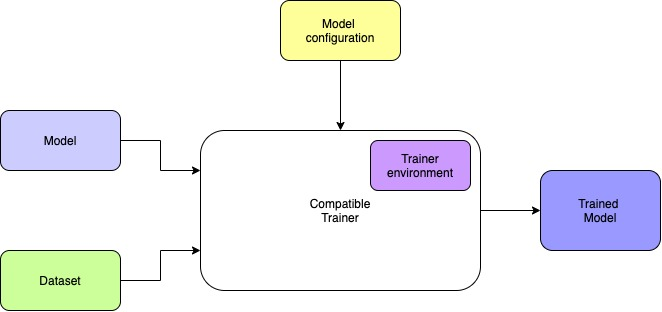

In [ ]:
config_params = model_config["params"]
trained_model = TFKerasTrainer.train(dataset_transformed,
                                     model,
                                     trainer_config,
                                     train_config={
                                         "LSTM_CLASSIFIER": {
                                             "representation": TR.TF_DATASET,
                                             'optimizer': tf.keras.optimizers.Adam(lr=config_params["initial_learning_rate"]),
                                             'loss': tf.keras.losses.CategoricalCrossentropy(),
                                             "epochs": config_params["epochs"],
                                             "metrics": ["accuracy"],
                                             "batch_size": config_params["batch_size"]
                                         }}
                                    )

The reporting process of the model provides us different values than its equivalent for `Dataset`. 

For this type of process, we get the model architecture and the model history, as shown:

In [ ]:
trained_model.reporter(results_path/"model", {})

In [ ]:
hist_path = Path(results_path/"model"/"LSTM_CLASSIFIER_history.json")
pprint(json.loads(hist_path.read_text()), indent=2)

Finally, we predict the `test` partition of the dataset with the model trained in the previous step.

In [ ]:
predicted_dataset = trained_model.predict(dataset=dataset_transformed,
                                          execution_config=None,
                                          prediction_config={
                                              "sparse_predictions": True,
                                              "ommit_uniques": True,
                                              "representation": TR.TF_DATASET
                                          })

predicted_dataset.data.head(10)

In [ ]:
predicted_dataset.reporter(results_path/"dataset_prediction", {})